In [ ]:
import torch
import torch.nn as nn
import math
import jieba
# from dataloader import TrainDataset
from transformers import BertTokenizer, BertModel

d_model = 512
n_head=8

In [7]:
# nn.Embedding随机初始化嵌入字典，训练过程中会更新

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        # vocab: 字典大小 d_model: 词向量维度
        # nn.Embedding是一个简单的查找表，用于存储固定字典和大小的嵌入。
        self.emb = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # x.shape = (batch_size, seq_len)
        return self.emb(x) * math.sqrt(self.d_model)

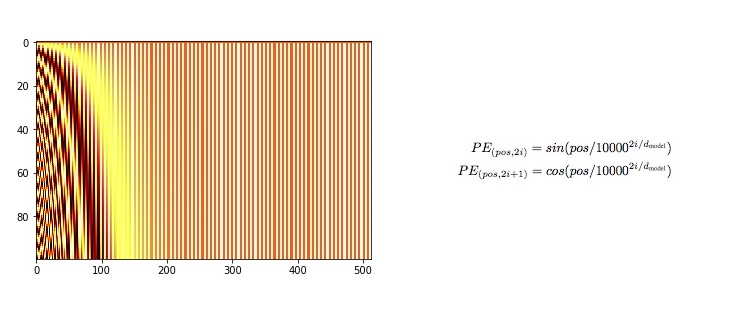

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, device):
        super(PositionalEncoding, self).__init__()

        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False

        pos = torch.arange(0, max_len, device=device).float().unsqueeze(1)
        # pos.shape = (max_len, 1)

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 取出d_model所有偶数位

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # 0::2表示从0开始，步长为2的切片，1::2表示从1开始，步长为2的切片

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        length = x.size(1)
        return self.encoding[:length, :]

In [ ]:
class transformer_embedding(nn.Module):
    def __init__(self,d_model,vocab_size,max_len,device):
        super(transformer_embedding, self).__init__()
        self.embedding = Embeddings(d_model, vocab_size)
        self.positional_encoding = PositionalEncoding(d_model, max_len, device)

    def forward(self, x):
        # x: [batch_size,seq_len]
        # return: [batch_size,seq_len,d_model]
        em = self.embedding(x)
        pos = self.positional_encoding(em)
        return em + pos

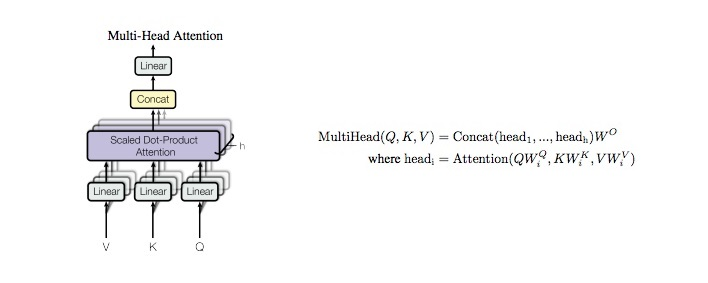
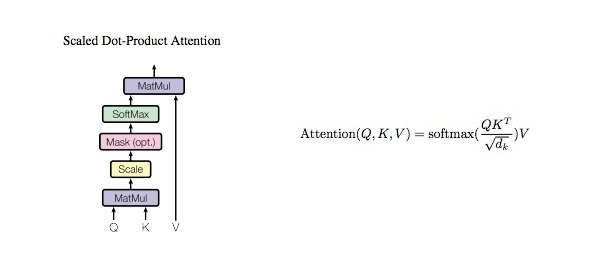


In [81]:
class Multi_head_attention(nn.Module):
    def __init__(self,d_model,n_head):
        self.n_head = n_head
        self.d_model = d_model
        super(Multi_head_attention, self).__init__()
        self.q_w = nn.Linear(d_model, d_model)
        self.k_w = nn.Linear(d_model, d_model)
        self.v_w = nn.Linear(d_model, d_model)
        self.ScaleDotProductAttention = ScaleDotProductAttention()
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # x: [batch_size,seq_len,d_model]
        # return: [batch_size,seq_len,d_model]

        q = self.q_w(q)
        k = self.k_w(k)
        v = self.v_w(v)
        q, k, v = [self.split_head(i) for i in [q, k, v]]
        # q,k,v: [batch_size,n_head,seq_len,d_head]

        out = self.ScaleDotProductAttention(q, k, v, mask)
        # out: [batch_size,n_head,seq_len,d_head]

        out = self.combine_head(out)
        # out: [batch_size,seq_len,d_model]
        out = self.w_concat(out)
        return out

    def split_head(self, x):
        # x: [batch_size,seq_len,d_model]
        # return: [batch_size,seq_len,n_head,d_head]
        batch_size, length, d_model = x.size()
        d_head = d_model // self.n_head
        return x.view(batch_size, length, self.n_head, d_head).transpose(1, 2)

    def combine_head(self, x):
        # x: [batch_size,n_head,seq_len,d_head]
        # return: [batch_size,seq_len,d_model]
        batch_size, n_head, length, d_head = x.size()
        # .contiguous() is used to make sure the memory is continuous
        return x.transpose(1, 2).contiguous().view(batch_size, length, n_head * d_head)
    

class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaleDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None):
        # q,k,v: [batch_size,n_head,seq_len,d_head]
        # return: [batch_size,n_head,seq_len,d_head]

        batch_size, head, length, d_head = k.size()

        k_t = k.transpose(2, 3)
        score = torch.matmul(q, k_t) / math.sqrt(d_head)

        # apply masking (opt)
        if mask is not None:
            score = score.masked_fill(mask == 0, -100000)
            # 将mask为0的位置替换为-100000，这样在softmax之后就会趋近于0

        out = torch.matmul(score, v)
        return out




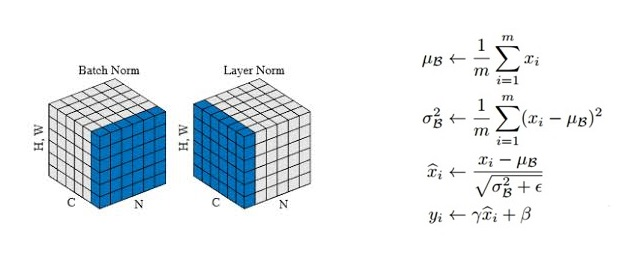

In [42]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()

        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        # x.shape = (batch_size, seq_len, d_model)  
        # return: (batch_size, seq_len, d_model)
        
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        # gamma和beta用于在归一化后对特征进行缩放和平移，以恢复一定的特征表示能力
        return out

In [ ]:
class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # x.shape = (batch_size, seq_len, d_model)
        # return: (batch_size, seq_len, d_model)
        
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [ ]:
class encodeer_layer(nn.Module):
    def __init__(self, d_model, n_head ,drop_prob):
        super(encodeer_layer, self).__init__()
        self.multi_head_attention = Multi_head_attention(d_model, n_head)
        self.layer_norm1 = LayerNorm(d_model)
        self.feed_forward = PositionwiseFeedForward(d_model, 512)
        self.layer_norm2 = LayerNorm(d_model)
        self.dropout = nn.Dropout(p=drop_prob)


    def forward(self, x, src_mask):
        # x: [batch_size,seq_len,d_model]
        # return: [batch_size,seq_len,d_model]
        _x = x
        x = self.multi_head_attention(q=x, k=x, v=x, mask=src_mask)

        x = self.dropout(x)
        x = self.layer_norm1(x + _x)

        _x = x
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = self.layer_norm2(x + _x)
        return x
    
class Encoder(nn.Module):
    def __init__(self, d_model, n_head, num_layers, drop_prob,vocab_size,device):
        super(Encoder, self).__init__()
        self.embedding = transformer_embedding(d_model, vocab_size, 1000, device)
        self.layers = nn.ModuleList([encodeer_layer(d_model, n_head, drop_prob) for _ in range(num_layers)])

    def forward(self, x, src_mask):
        # x: [batch_size,seq_len]
        # src_mask: [batch_size,seq_len]
        # return: [batch_size,seq_len,d_model]
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, drop_prob):
        super(DecoderLayer, self).__init__()
        self.masked_multi_head_attention = Multi_head_attention(d_model, n_head)
        self.layer_norm1 = LayerNorm(d_model)
        self.multi_head_attention = Multi_head_attention(d_model, n_head)
        self.layer_norm2 = LayerNorm(d_model)
        self.feed_forward = PositionwiseFeedForward(d_model, 512)
        self.layer_norm3 = LayerNorm(d_model)
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x, enc_out, trg_mask, src_mask):
        # x: [batch_size,seq_len,d_model]
        # enc_out: [batch_size,seq_len,d_model]
        # return: [batch_size,seq_len,d_model]
        _x = x
        x = self.masked_multi_head_attention(q=x, k=x, v=x, mask=trg_mask)
        x = self.dropout(x)
        x = self.layer_norm1(x + _x)

        _x = x
        x = self.multi_head_attention(q=x, k=enc_out, v=enc_out, mask=src_mask)
        x = self.dropout(x)
        x = self.layer_norm2(x + _x)

        _x = x
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = self.layer_norm3(x + _x)
        return x


class Decoder(nn.Module):
    def __init__(self, d_model, n_head, num_layers, drop_prob, vocab_size, device):
        super(Decoder, self).__init__()
        self.embedding = transformer_embedding(d_model, vocab_size, 1000, device)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_head, drop_prob) for _ in range(num_layers)])

    def forward(self, x, enc_out, trg_mask, src_mask):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, enc_out, trg_mask, src_mask)
        return x

In [ ]:
class transformer(nn.Module):
    def __init__(self, d_model, n_head, num_layers, drop_prob, vocab_size, device):
        super(transformer, self).__init__()
        self.device = device
        self.encoder = Encoder(d_model, n_head, num_layers, drop_prob, vocab_size, device)
        self.decoder = Decoder(d_model, n_head, num_layers, drop_prob, vocab_size, device)
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, src, trg, src_mask, trg_mask):
        src_mask = self.make_src_mask(src_mask)
        trg_mask = self.make_trg_mask(trg, trg_mask)
        enc_out = self.encoder(src, src_mask)
        dec_out = self.decoder(trg, enc_out, trg_mask, src_mask)
        out = self.linear(dec_out)
        return out
    
    def make_src_mask(self, src_mask):
        src_mask = src_mask.unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_trg_mask(self, trg, trg_mask):
        trg_pad_mask  = trg_mask.unsqueeze(1).unsqueeze(3)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones(trg_len, trg_len)).type(torch.ByteTensor).to(self.device)
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask